### <div align="center">***CLASIFICACION DE CITOLOGIAS***</div>
***
Clasificador automatico de imágenes de citologías cervicovaginales al microscopio óptico mediante redes neuronales convolucionales (supervisado).

##### **IMPORT LIBRARIES AND UTILS** 

In [1]:
from utils import IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS, BATCH_SIZE, EPOCHS, DATA_PATH, loadImage, balanceData

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
                    
from skimage.io import imread 
import cv2                    

from sklearn.model_selection import train_test_split    
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

##### **TRAINING**

In [2]:
# DATAFRAME CON LOS ARCHIVOS DE IMAGEN DEL DATASET

files_column = os.listdir(DATA_PATH)  # Lista de los nombres de los archivos en el directorio especificado.
category_column = [0 if 'normal' in file else 1 for file in files_column]  # Columna con la categoría de cada archivo: 0 celulas normales, 1 celulas atipicas.
df_modelo = pd.DataFrame({
            'file_name' : files_column,
            'category' : category_column })

df_modelo

,file_name,category
0,atipica- (1).bmp,1
1,atipica- (10).bmp,1
2,atipica- (100).bmp,1
3,atipica- (1000).bmp,1
4,atipica- (1001).bmp,1
...,...,...
4044,normal- (995).bmp,0
4045,normal- (996).bmp,0
4046,normal- (997).bmp,0
4047,normal- (998).bmp,0


Category 0: 2411
Category 1: 1638
Total data: 4049


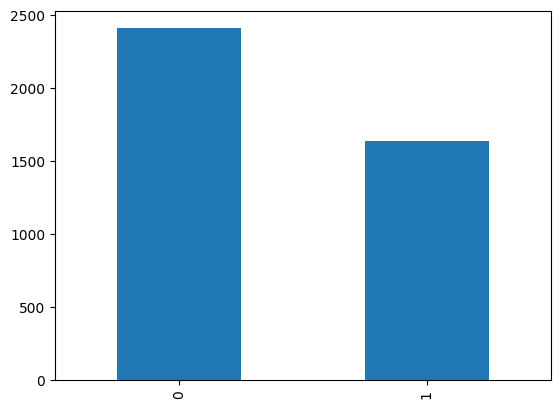

In [3]:
# BALANCE DE DATOS EN LAS CATEGORIAS

print("Category 0:", len(df_modelo[df_modelo['category']==0]))
print("Category 1:", len(df_modelo[df_modelo['category']==1]))
print("Total data:", len(df_modelo['category']))

df_modelo['category'].value_counts().plot.bar(); 

In [26]:
files = balanceData(DATA_PATH)[0] # Balanceamos las categorias y nos quedamos con el dataset balanceado -> [0]

In [29]:
# DATAFRAME CON LOS ARCHIVOS DE IMAGEN DEL DATASET (BALANCEADO)

category = [0 if 'normal' in file else 1 for file in files] # Columna con la categoría de cada archivo: 0 celulas normales, 1 celulas atipicas.
df_cito = pd.DataFrame({
            'file_name' : files,
             'category' :category }).sample(frac=1, random_state=14, ignore_index=True) # Aleatorizamos el orden de las filas

df_cito

,file_name,category
0,normal- (864).bmp,0
1,normal- (46).bmp,0
2,normal- (1176).bmp,0
3,normal- (1607).bmp,0
4,normal- (2226).bmp,0
...,...,...
3271,atipica- (188).bmp,1
3272,atipica- (259).bmp,1
3273,normal- (534).bmp,0
3274,normal- (626).bmp,0


Category 0: 1638
Category 1: 1638
Total data: 3276


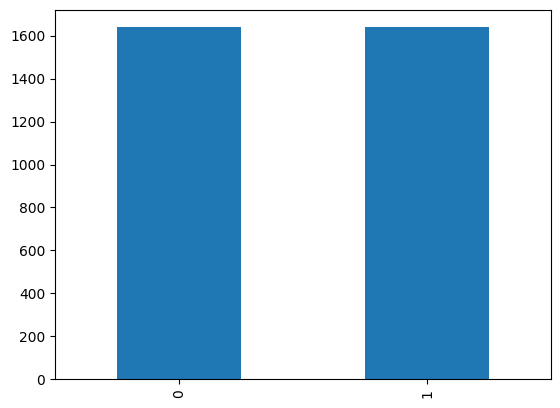

In [28]:
print("Category 0:", len(df_cito[df_cito['category']==0]))
print("Category 1:", len(df_cito[df_cito['category']==1]))
print("Total data:", len(df_cito['category']))
df_cito['category'].value_counts().plot.bar(); 

##### **LOAD AND RESIZE DATA**

Usamos la funcion loadImage() para cargar las imágenes y ajustarlas todas a la misma resolución, es decir hacerles un resize (dimensiones).  

Decidimos cargarlas en color porque el scoring del modelo mejoraba considerablemente si no reducimos los features con escala de grises (probamos previamente ambas opciones).

In [30]:
X,Y = loadImage(files, DATA_PATH, IMAGE_HEIGHT, IMAGE_WIDTH) # Almacenamos las imagenes procesadas, con el resize aplicado.

##### **SPLIT DE SUBGRUPOS: TRAIN, TEST, VALIDATION**

El split de los grupos para el entrenamiento del modelo lo determinamos con la siguiente fórmula:

- **Train:**  ```len(df_cito[df_cito['category']==0]) * 2 * 0.8```  

- **Test:**  ```len(df_cito[df_cito['category']==0]) * 2 * 0.2```

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size= 0.8, random_state=14, shuffle=True, stratify=Y) # Split subsets de train-test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2620, 350, 350, 3)
(656, 350, 350, 3)
(2620,)
(656,)


##### **ESCALADO DE DATOS**

Todos los valores de los pixeles entre 0 y 1.

In [36]:
X_train = X_train/255 # Podríamos aplicar skalearn.preprocessing.MinMaxScaler, pero este cálculo es más óptimo. Valor min de pixel: 0 , Valor max de pixel: 255 
X_test = X_test/255

print('Min value:',np.min(X_train))
print('Max value:',np.max(X_train))

Min: 0.00019992310649750097
Max: 0.00392156862745098


##### **GUARDAR/CARGAR DATOS**

In [35]:
np.savez('../models/data.npz', X_train  =X_train, y_train = y_train, X_test = X_test, y_test = y_test)

In [80]:
data = np.load('../models/data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

##### **ARQUITECTURA DEL MODELO**


1. **Tres capas convolucionales** con 32, 64 y 128 kernels respectivamente, con dimensión 3x3 y función de activación relu.  
Tras cada capa convolucional se aplica una capa de reducción 2x2 (max pooling) y una capa de dorpout 0.25.

2. **Tres capas de clasificación**:
   - Input layer. Aplanamiento de los datos en la red (flatten)
   - Hiden layer. Compuesta por una capa de 512 neuronas con función de activación relu y una capa de dropout 0.5.
   - Output layer. Compuesta por una única neurona con función de activación sigmoide, ideal al ser un clasificador binario. Otra opción sería 2 neuronas con softmax func.

- **Opmizador**: adam.  

- **Función de error o pérdida**: binary crossentropy.

In [ ]:
model = Sequential()

## CAPAS DE CONVOLUCION-POOLING

# PRIMERA CAPA 
model.add(Conv2D(filters = 32, kernel_size= (3,3), activation='relu',
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# SEGUNDA CAPA
model.add(Conv2D(filters = 64, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# TERCERA CAPA
model.add(Conv2D(filters = 128, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


## CAPAS DE CLASIFICACION

# INPUT LAYER
model.add(Flatten())

# HIDEN LAYER
model.add(Dense(units = 512, activation= 'relu'))
model.add(Dropout(0.5))

# OUTPUT LAYER 
model.add(Dense(units= 1, activation= 'sigmoid'))



model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy']) 

In [ ]:
model.summary()

##### **FIT (entrenamiento)** 

In [ ]:
earlystop =EarlyStopping(patience= 3) # Interrumpe el entrenamiento cuando no ve progreso en el set de validación por tres veces consecutivas.
# checkpoint = ModelCheckpoint('../models/checkpoint_model.h5')

In [ ]:
history = model.fit(X_train,y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [earlystop]
                    validation_split = 0.2,
                    verbose = 1)  

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

##### **EVALUACION EN X_TEST**

In [ ]:
results = model.evaluate(X_test,y_test)
print("Métrica de test: loss y accuracy", results)

In [ ]:
model.predict(X_test).round(0)

In [ ]:
predictions = model.predict(X_test[-1:]).round(0)

In [ ]:
# MATRIZ DE CONFUCIÓN PARA EL CLASIFICADOR BINARIO

confusion_matrix(y_train, model.predict(X_train).round(0))

##### **SAVE MODEL** 

In [ ]:
model.save("../models/model_cool.h5") # model.save_weight() 

##### **TESTING MODEL** 

In [ ]:
# image = imread('cito_test.png')
# plt.imshow(image);

# testing_image = np.array([cv2.resize(imread('./cito_test.png'),(IMAGE_WIDTH,IMAGE_HEIGHT))/255.0])
# model.predict(testing_image)